In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn
# !{sys.executable} -m pip install --upgrade gensim
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install beautifulsoup4
# import nltk
# nltk.download('punkt')

In [150]:
import os
import re
import gensim
import multiprocessing
import random
import logging
import numpy as np
import zipfile
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from urllib import request

from pathlib import Path
from os import listdir
from os.path import isfile, join
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup

from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
SKIP_FILES = ""
NEWLINE = '\n'

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

"""
read training files
"""
def read_files(path):
    print("path: {}...".format(path))
    for root, dirnames, filenames in os.walk(path):
        for dirname in dirnames:
            read_files(os.path.join(root, dirname))
        for filename in filenames:
            if filename not in SKIP_FILES:
                filepath = os.path.join(root, filename)
                if os.path.isfile(filepath):
                    lines = []
                    f = open(filepath, encoding='latin-1')
                    for line in f:
                        lines.append(line)
                    f.close()
                    content = NEWLINE.join(lines)
                    yield filename, content

def download(url, filename):
    """Download a file if not present"""
    if not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [4]:
def get_data(url, filename):
    data_path = download(url, filename)
    documents = []
    print("building documents...")
    for fname, text in read_files(data_path):
        documents.append(clean_str(text).split(' '))
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]
    print("building documents done")
    return documents

##### Download Data Training

In [5]:
documents = get_data(url='https://github.com/kadriansyah/notebook/raw/master/alodokter-doc2vec-article/', filename="data.zip")
print("we have {} documents".format(len(documents)))

building documents...
path: data...
building documents done
we have 7932 documents


In [6]:
documents[0]

TaggedDocument(words=['penyebab', 'bayi', 'muntah', 'setelah', 'minum', 'asi', 'dan', 'cara', 'mengatasinya', 'bayi', 'muntah', 'setelah', 'minum', 'asi', '(', 'air', 'susu', 'ibu', ')', 'adalah', 'keluhan', 'yang', 'sering', 'terjadi', 'sebagian', 'bayi', 'bahkan', 'mengalaminya', 'hampir', 'setiap', 'kali', 'selesai', 'menyusu', 'meski', 'umumnya', 'normal', 'kondisi', 'ini', 'bisa', 'juga', 'disebabkan', 'oleh', 'gangguan', 'berbahaya', 'yang', 'harus', 'diwaspadai', 'bayi', 'muntah', 'setelah', 'minum', 'asi', 'dikenal', 'dengan', 'istilah', 'gumoh', 'gumoh', 'dikatakan', 'normal', 'apabila', 'tidak', 'menyebabkan', 'bayi', 'rewel', 'atau', 'sesak', 'napas', 'meskipun', 'dapat', 'dicegah', 'kondisi', 'tersebut', 'tidak', 'memerlukan', 'penanganan', 'khusus', 'dan', 'normal', 'terjadi', 'penyebab', 'bayi', 'muntah', 'setelah', 'minum', 'asi', 'gumoh', 'disebabkan', 'oleh', 'asi', 'atau', 'susu', 'yang', 'ditelan', 'bayi', 'kembali', 'ke', 'kerongkongan', 'karena', 'otot', 'di', 'sal

In [7]:
def evaluate(model, documents, steps):
    percentiles = np.zeros(steps)
    for step in range(steps):
        docid = np.random.randint(model.docvecs.count)
        inferred_vector = model.infer_vector(documents[docid][0])
        similars = model.docvecs.most_similar(positive=[inferred_vector], topn=10)
        for idx,simdoc in enumerate(similars):
            if simdoc[0] == docid:
                print("found similar document with id {} in position {} with similarity score {}".format(simdoc[0], idx, simdoc[1]))
                percentiles[step] = ((len(similars) - idx) / len(similars)) * 100
                break
    return np.mean(percentiles)

def train(documents=documents, model_name="model/alodokter-articles-doc2vec.model", max_epochs=50, patience=3):
    best_mean_percentiles = 0
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = Doc2Vec(dm=1, vector_size=300, window=2, alpha=0.1, min_alpha=0.0001, min_count=5, epochs=1, workers=5)
    model.build_vocab(documents)
    for epoch in range(max_epochs):
        print('training epoch {:d} ...'.format(epoch))
        model.train(documents, total_examples=model.corpus_count,epochs=model.epochs)
        mean_percentiles = evaluate(model,documents,10)
        print('mean percentiles: {:.2f}'.format(mean_percentiles))
        
        if mean_percentiles < best_mean_percentiles:
            print("current mean_percentiles: {:.2f}, best: {:.2f}".format(mean_percentiles, best_mean_percentiles))
            patience = patience-1
        else:
            best_mean_percentiles = mean_percentiles
            print("========== Saving best model with mean_percentiles: {:.2f} ==========".format(mean_percentiles))
            model.save(model_name)
            patience = patience+1
        
        if patience == 0:
            print("early stop...")
            print("========== Saving best model with mean_percentiles: {:.2f} ==========".format(best_mean_percentiles))
            break
    
    return model

##### Document to Vector Training

In [9]:
training = False
if training:
    model = train(documents)
else:
    print('loading documents...')
    model = Doc2Vec.load('model/alodokter-articles-doc2vec.model')
    print('loading documents done')

2020-02-24 10:28:54,776 : INFO : loading Doc2Vec object from model/alodokter-articles-doc2vec.model


loading documents...


2020-02-24 10:28:55,270 : INFO : loading vocabulary recursively from model/alodokter-articles-doc2vec.model.vocabulary.* with mmap=None
2020-02-24 10:28:55,271 : INFO : loading trainables recursively from model/alodokter-articles-doc2vec.model.trainables.* with mmap=None
2020-02-24 10:28:55,271 : INFO : loading wv recursively from model/alodokter-articles-doc2vec.model.wv.* with mmap=None
2020-02-24 10:28:55,272 : INFO : loading docvecs recursively from model/alodokter-articles-doc2vec.model.docvecs.* with mmap=None
2020-02-24 10:28:55,272 : INFO : loaded model/alodokter-articles-doc2vec.model


loading documents done


##### KMeans Clustering

In [112]:
# prepare vectors for training
trained_vectors = [model.docvecs[i] for i in range(len(model.docvecs))]

##### The Silhouette Method
##### reference: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means

In [136]:
from sklearn.metrics import silhouette_score

silhouette_scores  = []
kmax = 100

"""
dissimilarity would not be defined for a single cluster, thus minimum number of clusters should be 2
"""
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k).fit(trained_vectors)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(trained_vectors, labels, metric='euclidean'))

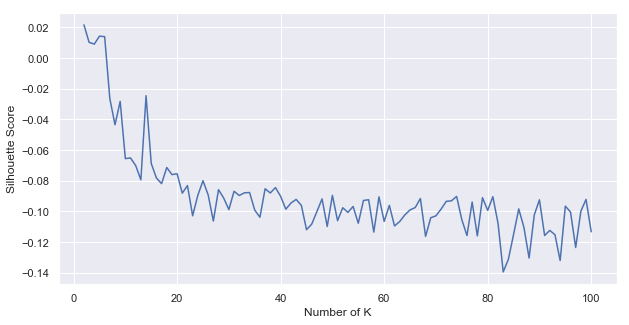

In [137]:
# Silhouette Score Result
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("Number of K")
plt.ylabel("Silhouette Score")

x = [k for k in range(2, kmax + 1)]
y = silhouette_scores
plt.plot(x,y)

##### Training or Load Trained Model

In [156]:
training = False
if training:
    n_clusters = 16
    trained_vectors = [model.docvecs[i] for i in range(len(model.docvecs))]
    print('clustering...')
    kmeans = KMeans(n_clusters=n_clusters).fit(trained_vectors)
    clusters = kmeans.labels_.tolist()
    # save the model
    pickle.dump(kmeans, open('model/kmeans.pkl','wb'))
    print('clustering done')
else:
    print('load model...')
    kmeans = pickle.load(open('model/kmeans.pkl', 'rb'))
    print('load model done')

load model...
load model done


In [157]:
# create dictionary doc-id to cluster-id
docs_clusters = {(idx, cluster) for idx, cluster in enumerate(clusters)}

##### Draw Cluster Diagram

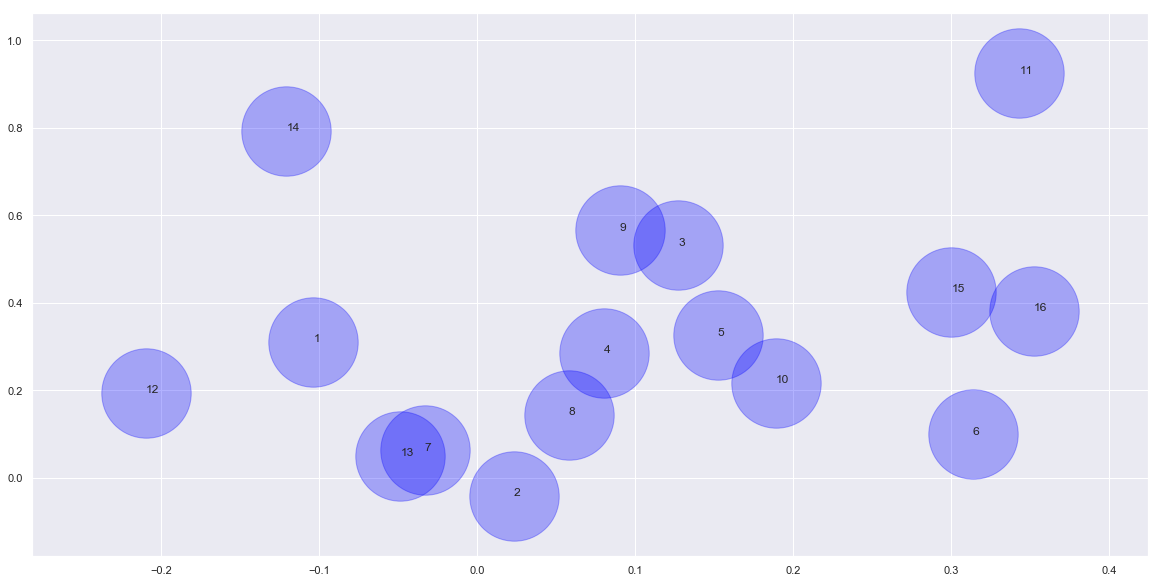

In [158]:
centroids = kmeans.cluster_centers_
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(centroids[:,0], centroids[:,1], c='blue', s=8000, alpha=0.3);
for i in range(0,n_clusters):
    plt.annotate(str(i+1), (centroids[i:i+1,0], centroids[i:i+1,1]))